# Targeted Bisulfite Sequencing Analysis
- GSE15923 Comparison of Methylation Capture Sequencing and Infinium EPIC Methylation Array in Peripheral Blood Mononuclear Cells
- Four individuals
    - blood mononuclear cells
    - input libraries prepared at >1000ng, 300-1000ng, <300ng
    - SureSlectXT Methyl-Seq (Aligent) kit
    - Illumina Epic Array Measurements for all samples

### Notebook Setup

In [1]:
from collections import Counter
import gzip
import io
import os
import pickle
import subprocess

import joblib
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scistats
import seaborn as sns
from tqdm.notebook import tqdm

### Retrieve Sample Data

In [3]:
base_dir = '~/BSBolt_Paper/real_data_comps/'

In [2]:
wgbs_comp_data = pd.read_csv(f'{base_dir}SraRunTable.txt', sep=',', index_col=0, header=0).T.to_dict()

In [4]:
output_dir = '~/BSBolt_Paper/real_data_comps/' 

In [5]:
fastq_dir = f'{base_dir}fastqs/'

In [6]:
stats_dir = os.getcwd() + '/run_stats/'

In [7]:
alignment_dir = f'{output_dir}alignments/'

## Format Series Matrix Data

In [8]:
epic_manifest = f'{base_dir}/infinium-methylationepic-v-1-0-b5-manifest-file.csv.gz'

In [9]:
epic_sites = {}

with io.BufferedReader(gzip.open(epic_manifest, 'rb')) as manifest:
    header = False
    for line in tqdm(manifest):
        processed_line = line.decode().strip().split(',')
        illumina_id = processed_line[0]
        if not header:
            if processed_line[0] == 'IlmnID':
                header = True
        else:
            # end loop when control sites are encountered
            try:
                illumina_id, chrom, start, end, strand = processed_line[0], processed_line[48], processed_line[49], processed_line[50], processed_line[51]
            except IndexError as e:
                break
            # skip sites not mapping to hg38
            try:
                start, end  = int(start), int(end)
            except ValueError as e:
                continue
            if strand == '-':
                pos = end - 1
            elif strand == '+':
                pos = start + 1
            epic_sites[illumina_id] = (chrom, pos, strand)

In [11]:
epic_bed = f'{base_dir}epic_target.bed'
if not os.path.exists(epic_bed):
    with open(epic_bed, 'w') as out:
        for key, value in epic_sites.items():
            out.write(f'{value[0]}\t{value[1]}\t{value[1]+1}\t{value[2]}\t{key}\n')

In [12]:
reverse_epic = {f'{site[0]}:{site[1]}':ill_id for ill_id, site in epic_sites.items()}

In [13]:
series_matrix_file = f'{base_dir}real_data_comps/array_data/GSE152923-GPL21145_series_matrix.txt.gz'

In [14]:
with io.BufferedReader(gzip.open(series_matrix_file, 'rb')) as series:
    header = None
    line_ids = []
    epic_values = []
    for line in tqdm(series):
        processed_line = line.decode().strip().split('\t')
        if not header:
            if processed_line[0].replace('"', '') == 'ID_REF':
                header = [sample.replace('"', '') for sample in processed_line[1:]]
        else:
            illumina_id = processed_line[0].replace('"', '')
            if illumina_id in epic_sites:
                line_values = []
                good_line = True
                for value in processed_line[1:]:
                    try:
                        line_values.append(float(value))
                    except ValueError:
                        good_line = False
                        break
                if good_line:
                    epic_head = epic_sites[illumina_id]
                    line_ids.append(f'{epic_head[0]}:{epic_head[1]}')
                    epic_values.append(np.array(line_values))

In [15]:
epic_df = pd.DataFrame(np.array(epic_values), columns=header, index=line_ids)

In [16]:
for sample in wgbs_comp_data:
    subject_index = int(wgbs_comp_data[sample]['subject']) - 1
    wgbs_comp_data[sample]['gsm_comp'] = list(epic_df)[subject_index]

### Get Fastq Read Info 

In [17]:
def count_lines(file, sample):
    line_count = 0
    with io.BufferedReader(gzip.open(file, 'rb')) as count_file:
        for line in count_file:
            line_count += 1
    return sample, line_count / 4

In [18]:
#read_counts = joblib.Parallel(n_jobs=12, verbose=10)(joblib.delayed(count_lines)(*[f'{fastq_dir}{sample}_1.fastq.gz', sample]) for sample in wgbs_comp_data)
read_counts = [('SRR12063108', 138348753.0),
 ('SRR12063109', 120715237.0),
 ('SRR12063110', 180577155.0),
 ('SRR12063111', 230599701.0),
 ('SRR12063112', 129844502.0),
 ('SRR12063113', 146466192.0),
 ('SRR12063114', 126175580.0),
 ('SRR12063115', 145978110.0),
 ('SRR12063116', 134245818.0),
 ('SRR12063117', 119382239.0),
 ('SRR12063118', 140496811.0),
 ('SRR12063119', 118507931.0)]
read_counts = {sample:count for sample, count in read_counts}

In [19]:
read_count_values = np.array(list(read_counts.values()))
print(int(np.mean(read_count_values)), max(read_count_values), min(read_count_values))

144278169 230599701.0 118507931.0


### Import Read Stats

In [20]:
def load_run_stats(stats_dir, sample_name, tool):
    if os.path.exists(f'{stats_dir}{sample_name}_{tool}_2_alignment_node_stats.pkl'):
        with open(f'{stats_dir}{sample_name}_{tool}_2_alignment_node_stats.pkl', 'rb') as ns:
            node_stats = pickle.load(ns)
    else:
        node_stats = {}
    with open(f'{stats_dir}{sample_name}_{tool}_2_alignment_stats.pkl', 'rb') as aln_sts:
        align_stats = pickle.load(aln_sts)
    with open(f'{stats_dir}{sample_name}_{tool}_2_meth_call_stats.pkl', 'rb') as mc_sts:
        call_stats = pickle.load(mc_sts)
    return node_stats, align_stats, call_stats

In [21]:
tool_names = {'biscuit': 'BISCUIT', 'bwa_meth': 'BWA-Meth', 'BSBolt':'BSBolt', 'bismark':'Bismark', 'bsseeker':'BSSeeker2'}

In [22]:
alignment_stats = {}

for tool in ['BSBolt', 'biscuit', 'bwa_meth', 'bsseeker', 'bismark']:
    for sample in wgbs_comp_data:
        alignment = f'{sample}_{tool}'
        alignment_file = f'{alignment_dir}{alignment}.dup.bam'
        if tool == 'bismark':
            alignment_file = f'{alignment_dir}{alignment}/{sample}_1_bismark_bt2_pe.dup.bam'
        alignment_stats[alignment] = dict(alignment_file=alignment_file, tool=tool, PairedEndReads=read_counts[sample])
        if os.path.exists(f'{stats_dir}{sample}_{tool}_alignment_stats.pkl'):
            node, align, call = load_run_stats(stats_dir, sample, tool)
            alignment_stats[alignment]['Tool'] = tool_names[tool]
            alignment_stats[alignment]['meth_call_time'] = call[0]
            alignment_stats[alignment].update(node)
            if align[0]:
                alignment_stats[alignment]['alignment_time'] = align[0]
                alignment_stats[alignment]['alignment_complete'] = True
            else:
                alignment_stats[alignment]['alignment_time'] = 24 * 60 * 60 
                alignment_stats[alignment]['alignment_complete'] = False

In [23]:
# run samtools flagstat on each sample and parse output 
# command will fail if samtools is not on path
def get_flagstats(sample_path, sample_name):
    sam_stats = {}
    sam_args = ['samtools', 'flagstat', '-@', '8', sample_path]
    with subprocess.Popen(args=sam_args, stdout=subprocess.PIPE, universal_newlines=True) as sam_process:
        for count, line in enumerate(iter(sam_process.stdout)):
            if count == 0:
                sam_stats['Total Alignments']= int(line.split(' ')[0])
                sam_stats['Total Alignment QC-Failed'] = int(line.split(' ')[2]) 
            elif count == 1:
                sam_stats['Secondary Alignments'] = int(line.split(' ')[0])
                sam_stats['Secondary Alignments QC-Failed'] = int(line.split(' ')[2])
            elif count == 2:
                sam_stats['Supplementary Alignments']= int(line.split(' ')[0])
                sam_stats['Supplementary Alignments QC-Failed']= int(line.split(' ')[2])
            elif count == 3:
                sam_stats['Duplicate Alignments']= int(line.split(' ')[0])
                sam_stats['Duplicate Alignments QC-Failed']= int(line.split(' ')[2])
            elif count == 4:
                sam_stats['Mapped Alignments']= int(line.split(' ')[0])
                sam_stats['Mapped Alignments QC-Failed']= int(line.split(' ')[2])
            elif count == 5:
                sam_stats['Paired in Sequencing']= int(line.split(' ')[0])
                sam_stats['Paired in Sequencing QC-Failed']= int(line.split(' ')[2])
            elif count == 6:
                sam_stats['Read1']= int(line.split(' ')[0])
                sam_stats['Read1 QC-Failed']= int(line.split(' ')[2])
            elif count == 7:
                sam_stats['Read2']= int(line.split(' ')[0])
                sam_stats['Read2 QC-Failed']= int(line.split(' ')[2])
            elif count == 8:
                sam_stats['Properly Paired Alignments']= int(line.split(' ')[0])
                sam_stats['Properly Paired Alignments QC-Failed']= int(line.split(' ')[2])
            elif count == 9:
                sam_stats['Mate Mapped']= int(line.split(' ')[0])
                sam_stats['Mate Mapped QC-Failed']= int(line.split(' ')[2])
            elif count == 10:
                sam_stats['Singletons']= int(line.split(' ')[0])
                sam_stats['Singletons QC-Failed']= int(line.split(' ')[2])
            elif count == 11:
                sam_stats['Mate Mapped to Different Chromosome']= int(line.split(' ')[0])
                sam_stats['Mate Mapped to Different Chromosome QC-Failed']= int(line.split(' ')[2])
            elif count == 12:
                sam_stats['Mate Mapped to Different Chromosome (mapq>=5)']= int(line.split(' ')[0])
                sam_stats['Mate Mapped to Different Chromosome (mapq>=5) QC-Failed']= int(line.split(' ')[2])
    return sample_name, sam_stats

In [24]:
for sample in alignment_stats:
    alignment_stats[sample]['alignment_file'] = alignment_stats[sample]['alignment_file'].replace(base_dir, alignment_dir)

In [25]:
if not os.path.exists(f'{base_dir}wgbs_flag_stats'):
    flag_stats = joblib.Parallel(n_jobs=16, verbose=10)(joblib.delayed(get_flagstats)(*[sample_values['alignment_file'], sample]) for sample, sample_values in alignment_stats.items())
    with open(f'{base_dir}wgbs_flag_stats', 'wb') as out:
        pickle.dump(flag_stats, out)
else:
    with open(f'{base_dir}wgbs_flag_stats', 'rb') as fs:
        flag_stats = pickle.load(fs)

In [26]:
for sample, alignment_flags in flag_stats:
    sra_id = sample.split('_')[0]
    alignment_stats[sample].update(wgbs_comp_data[sra_id])
    alignment_stats[sample].update(alignment_flags)

## Methylation Call Helpers

In [27]:
def open_methylation_file(methylation_file, tool='BSBolt'):
    site_description = {'chrom':0, 'pos':2, 'meth_cyto':6, 'total_cyto':7}
    if tool == 'biscuit':
        site_description = {'chrom':0, 'pos':1, 'beta':3, 'total_cyto':4}
    elif tool == 'bwa_meth':
        site_description = {'chrom':0, 'pos':1, 'meth_cyto':4, 'unmeth_cyto':5}
    elif tool == 'bismark':
        site_description = {'chrom':0, 'pos':1, 'meth_cyto':3, 'unmeth_cyto':4}
    with open(methylation_file, 'r') as meth:
        for site in meth:
            site_split = site.strip().split('\t')
            f_values = {key:None for key in site_description.keys()}
            try:
                for key, value in site_description.items():
                    f_values[key] = site_split[value]
            except IndexError as e:
                print(site_split)
                raise e
            yield f_values

In [28]:
def get_formatted_methylation(methylation_file, tool='BSBolt'):
    # chrom, site, converted, total_bases
    formatted_methylation_calls = {}
    for line in open_methylation_file(methylation_file, tool):
        # chrom, pos, meth_cyto, unmeth_cyto
        formatted_line = [line['chrom']]
        if tool == 'biscuit':
            formatted_line.append(int(line['pos']))
            meth_cyto = int(round(float(line['beta']) * float(line['total_cyto'])))
            unmeth_cyto = int(line['total_cyto']) - meth_cyto
            formatted_line.extend([meth_cyto, unmeth_cyto])
        elif tool == 'BSBolt' or tool == 'bsseeker':
            formatted_line.append(int(line['pos']) - 1)
            formatted_line.append(int(line['meth_cyto']))
            formatted_line.append(int(line['total_cyto']) - int(line['meth_cyto']))
        elif tool == 'bwa_meth':
            # skip header lines
            try:
                formatted_line.append(int(line['pos']))
            except ValueError:
                continue
            formatted_line.append(int(line['meth_cyto']))
            formatted_line.append(int(line['unmeth_cyto']))
        elif tool == 'bismark':
            # skip header lines
            formatted_line.append(int(line['pos']) - 1)
            formatted_line.append(int(line['meth_cyto']))
            formatted_line.append(int(line['unmeth_cyto']))
        assert len(formatted_line) == 4
        if formatted_line[2] + formatted_line[3] >= 5:
            formatted_methylation_calls[f'{formatted_line[0]}:{formatted_line[1]}'] = (formatted_line[2], formatted_line[3])
    return formatted_methylation_calls

In [29]:
for alignment_label in alignment_stats:
    alignment_out = alignment_stats[alignment_label]['alignment_file'].replace('.bam', '')
    tool = alignment_stats[alignment_label]['tool']
    call_file = f'{alignment_out}.bam.meth_out.CGmap'
    if tool == 'bsseeker':
        call_file = f'{alignment_out}.bam.meth_out'
    elif tool == 'bwa_meth':
        call_file = f'{alignment_out}.methylation.txt'
    elif tool == 'biscuit':
        call_file = f'{alignment_out}.bam.meth_out_biscuit_out'
    elif tool == 'bismark':
        call_label = alignment_out.replace('.dup', '').split('/')[-1]
        call_file = f'{alignment_out.replace(".dup", "")}.name.bam.meth_out/{call_label}.name.CpG_report.txt'
    alignment_stats[alignment_label]['call_file'] = call_file

In [30]:
def check_file(file_path):
    if not os.path.exists(file_path):
        return 1
    if os.path.getsize(file_path) < 100:
        return 1
    return 0

In [31]:
incomplete_samples = set()

for label, values in alignment_stats.items():
    if check_file(values['call_file']):
        incomplete_samples.add(label)
        print(label, values['call_file'])

## Compare Alignment Calls to Array Calls

In [32]:
alignment_stats = {key: value for key, value in alignment_stats.items() if key not in incomplete_samples}

In [33]:
def get_comparison_data(sra_id, comp_data, comp_df):
    return comp_df[comp_data[sra_id]['gsm_comp']].to_dict()

In [34]:
def assess_methylation_call(call_file, tool, array_info, call_label):
    calls = get_formatted_methylation(call_file, tool)
    unshared_calls = 0 
    shared_stats = {}
    for call_site, call_info in calls.items():
        if call_site in array_info:
            array_beta = array_info[call_site]
            call_beta = call_info[0] / (call_info[0] + call_info[1])
            shared_stats[call_site] = [call_beta, array_beta, call_info[0] + call_info[1]]
        else:
            unshared_calls += 1
    return shared_stats, unshared_calls, call_label

In [35]:
if not os.path.exists(f'{base_dir}array_call_comps'):
    array_call_comps = joblib.Parallel(n_jobs=16, verbose=10)(joblib.delayed(assess_methylation_call)(*[sample_values['call_file'], 
                                                                                                        sample_values['tool'], 
                                                                                                        get_comparison_data(sample.split('_')[0], wgbs_comp_data, epic_df),
                                                                                                        sample]) 
                                                              for sample, sample_values in alignment_stats.items())
    with open(f'{base_dir}array_call_comps', 'wb') as out:
        pickle.dump(array_call_comps, out)
else:
    with open(f'{base_dir}array_call_comps', 'rb') as fs:
        array_call_comps = pickle.load(fs)

In [36]:
call_comps = {call[2]: (call[0], call[1]) for call in array_call_comps}

In [37]:
c = Counter()

for comp in array_call_comps:
    c.update(comp[0].keys())

In [38]:
consensus_sites = set()

for site, count in c.items():
    if count >= 1:
        consensus_sites.add(site)

In [39]:
def get_comp_beta(comp):
    call_betas = np.array([site[0] for site in comp.values()])
    array_betas = np.array([site[1] for site in comp.values()])
    call_coverage = np.array([site[2] for site in comp.values()])
    return call_betas, array_betas, call_coverage

In [40]:
def array_comps_stats(call_betas, array_betas, call_coverage):
    try:
        r2 = scistats.pearsonr(call_betas, array_betas)[0]**2
    except ValueError:
        r2 = 0.0
    return r2, len(comp), np.mean(abs(call_betas - array_betas)), np.std(abs(call_betas - array_betas)), np.mean(call_coverage), np.std(call_coverage)

In [41]:
meth_call_comp_stats = {}
dna_input = {'array_betas':np.array([]), 'call_coverage':np.array([]), 'array_seq_diff':np.array([])}
meth_call_comp_values = {tool:{'High DNA input':dict(dna_input), 'Medium DNA input':dict(dna_input), 'Low DNA input':dict(dna_input)} for tool in tool_names}

for comp in tqdm(array_call_comps):
    array_read_coverage = None
    stats_comp = {}
    try:
        sra_id, tool = comp[2].split('_')
    except ValueError:
        sra_id = comp[2].split('_')[0]
        tool = 'bwa_meth'
    for key, value in comp[0].items():
        if key in consensus_sites:
            stats_comp[key] = value
    sra_input = wgbs_comp_data[sra_id]['DNA_input']
    call_betas, array_betas, call_coverage = get_comp_beta(stats_comp)
    
    # save call value per dna input
    meth_call_comp_values[tool][sra_input]['array_betas'] = np.append(meth_call_comp_values[tool][sra_input]['array_betas'], array_betas)
    meth_call_comp_values[tool][sra_input]['call_coverage'] = np.append(meth_call_comp_values[tool][sra_input]['call_coverage'], call_coverage)
    meth_call_comp_values[tool][sra_input]['array_seq_diff'] = np.append(meth_call_comp_values[tool][sra_input]['array_seq_diff'], array_betas - call_betas)
    
    # save call comp stats
    cats = ['R2', 'CpG Number', 'MAE', 'MAE_STD', 'Mean Coverage', 'STD Coverage']
    cleaned_comps = {cat: value for cat, value in zip(cats, array_comps_stats(call_betas, array_betas, call_coverage))}
    cleaned_comps['tool'] = tool
    cleaned_comps['sra'] = sra_id
    cleaned_comps.update(wgbs_comp_data[sra_id])
    alignment_stats[comp[2]].update(cleaned_comps)

### Format Comparison DF

In [42]:
for sample, run in alignment_stats.items():
    run['QC-Failed Alignments'] = sum([value for key, value in run.items() if 'QC-Failed' in key])

In [43]:
comp_df = pd.DataFrame(alignment_stats).T

In [44]:
comp_df['Mapped Reads'] = comp_df['Mapped Alignments'] - comp_df['Secondary Alignments'] - comp_df['Supplementary Alignments']
comp_df['Observed Reads'] = (comp_df['Total Alignments'] + comp_df['Total Alignment QC-Failed'] - 
                             comp_df['Secondary Alignments'] - comp_df['Secondary Alignments QC-Failed'] - 
                             comp_df['Supplementary Alignments'] -  comp_df['Supplementary Alignments QC-Failed'])
comp_df['Unaligned Reads'] = (comp_df['PairedEndReads'] * 2) - comp_df['Mapped Reads']
comp_df['Mappability'] = comp_df['Mapped Reads'] / (comp_df['PairedEndReads'] * 2)
comp_df['Read Pairs Aligned / Minute'] = (comp_df['Observed Reads'] / 2) / (comp_df['alignment_time'] / 60)

comp_df['Unobserved Reads'] = (comp_df['PairedEndReads'] * 2) - (comp_df['Total Alignments'] + comp_df['Total Alignment QC-Failed'] - 
                                                                 comp_df['Supplementary Alignments'] - comp_df['Supplementary Alignments QC-Failed'] - 
                                                                 comp_df['Secondary Alignments'] - comp_df['Secondary Alignments QC-Failed'])
comp_df['Duplication Rate'] = comp_df['Duplicate Alignments'] / comp_df['Mapped Alignments']
comp_df['Methylation Call Time (min)'] = comp_df['meth_call_time'] / 60
comp_df['Alignment Time (hrs)'] = comp_df['alignment_time'] / 60 / 60

In [45]:
comp_df['DNA Input'] = comp_df[['DNA_input', 'dna_input_quantity']].apply(lambda x: f'{x[0].replace(" DNA input", "")} ({x[1]})', axis=1)

In [46]:
comp_cats = ['Tool',
 'GEO_Accession (exp)',
 'sra',
 'subject',
 'DNA Input',
 'PairedEndReads',
 'Mapped Reads', 
 'Unaligned Reads',
 'Unobserved Reads',
 'Mappability',
 'Read Pairs Aligned / Minute',
 'Alignment Time (hrs)',
 'Total Alignments',
 'Secondary Alignments',
 'Supplementary Alignments',
 'Duplicate Alignments',
 'Properly Paired Alignments',
 'QC-Failed Alignments',
 'MAE',
 'MAE_STD',
 'Pearson\'s R',
 'Mean Coverage',
 'STD Coverage',
 'Methylation Call Time (min)']

In [47]:
comp_df = comp_df[comp_cats]

In [48]:
comp_df.columns =['Tool',
 'GEO Accession',
 'SRA ID',
 'Biological Sample',
 'DNA Input',
 'Paired End Reads',
 'Mapped Reads',
 'Unaligned Reads',
 'Unobserved Reads',
 'Mappability',
 'Read Pairs Aligned / Minute',
 'Alignment Time (hrs)',
 'Total Alignments',
 'Secondary Alignments',
 'Supplementary Alignments',
 'Duplicate Alignments',
 'Properly Paired Alignments',
 'QC-Failed Alignments',
 'Mean Absolute Difference (Array, Sequencing Methylation Calls)',
 'Mean Absolute Difference Std. Dev.',
 'Pearson\'s R (Array, Sequencing Methylation Calls)',
 'Mean CpG Read Coverage',
 'Mean CpG Read Coverage Std. Dev.',
 'Methylation Call Time (min)']

### Plot Comparisons

In [49]:
coverage_bins = np.array([10, 20, 30, 40, 50, 75, 100, 125, 150, 200, 300])

In [50]:
methylation_bins = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])

In [51]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 22

In [52]:
## format_coverages

array_diff = np.array([])
coverage = np.array([])
coverage_tools = []

for tool, tool_label in tool_names.items():
    for input_amount in ['High', 'Medium', 'Low']:
        array_diff = np.append(array_diff, abs(meth_call_comp_values[tool][f'{input_amount} DNA input']['array_seq_diff']))
        coverage = np.append(coverage, meth_call_comp_values[tool][f'{input_amount} DNA input']['call_coverage'])
        coverage_tools.extend([tool_label for _ in range(len(meth_call_comp_values[tool][f'{input_amount} DNA input']['call_coverage']))])

In [53]:
set(coverage_tools)

{'BISCUIT', 'BSBolt', 'BSSeeker2', 'BWA-Meth', 'Bismark'}

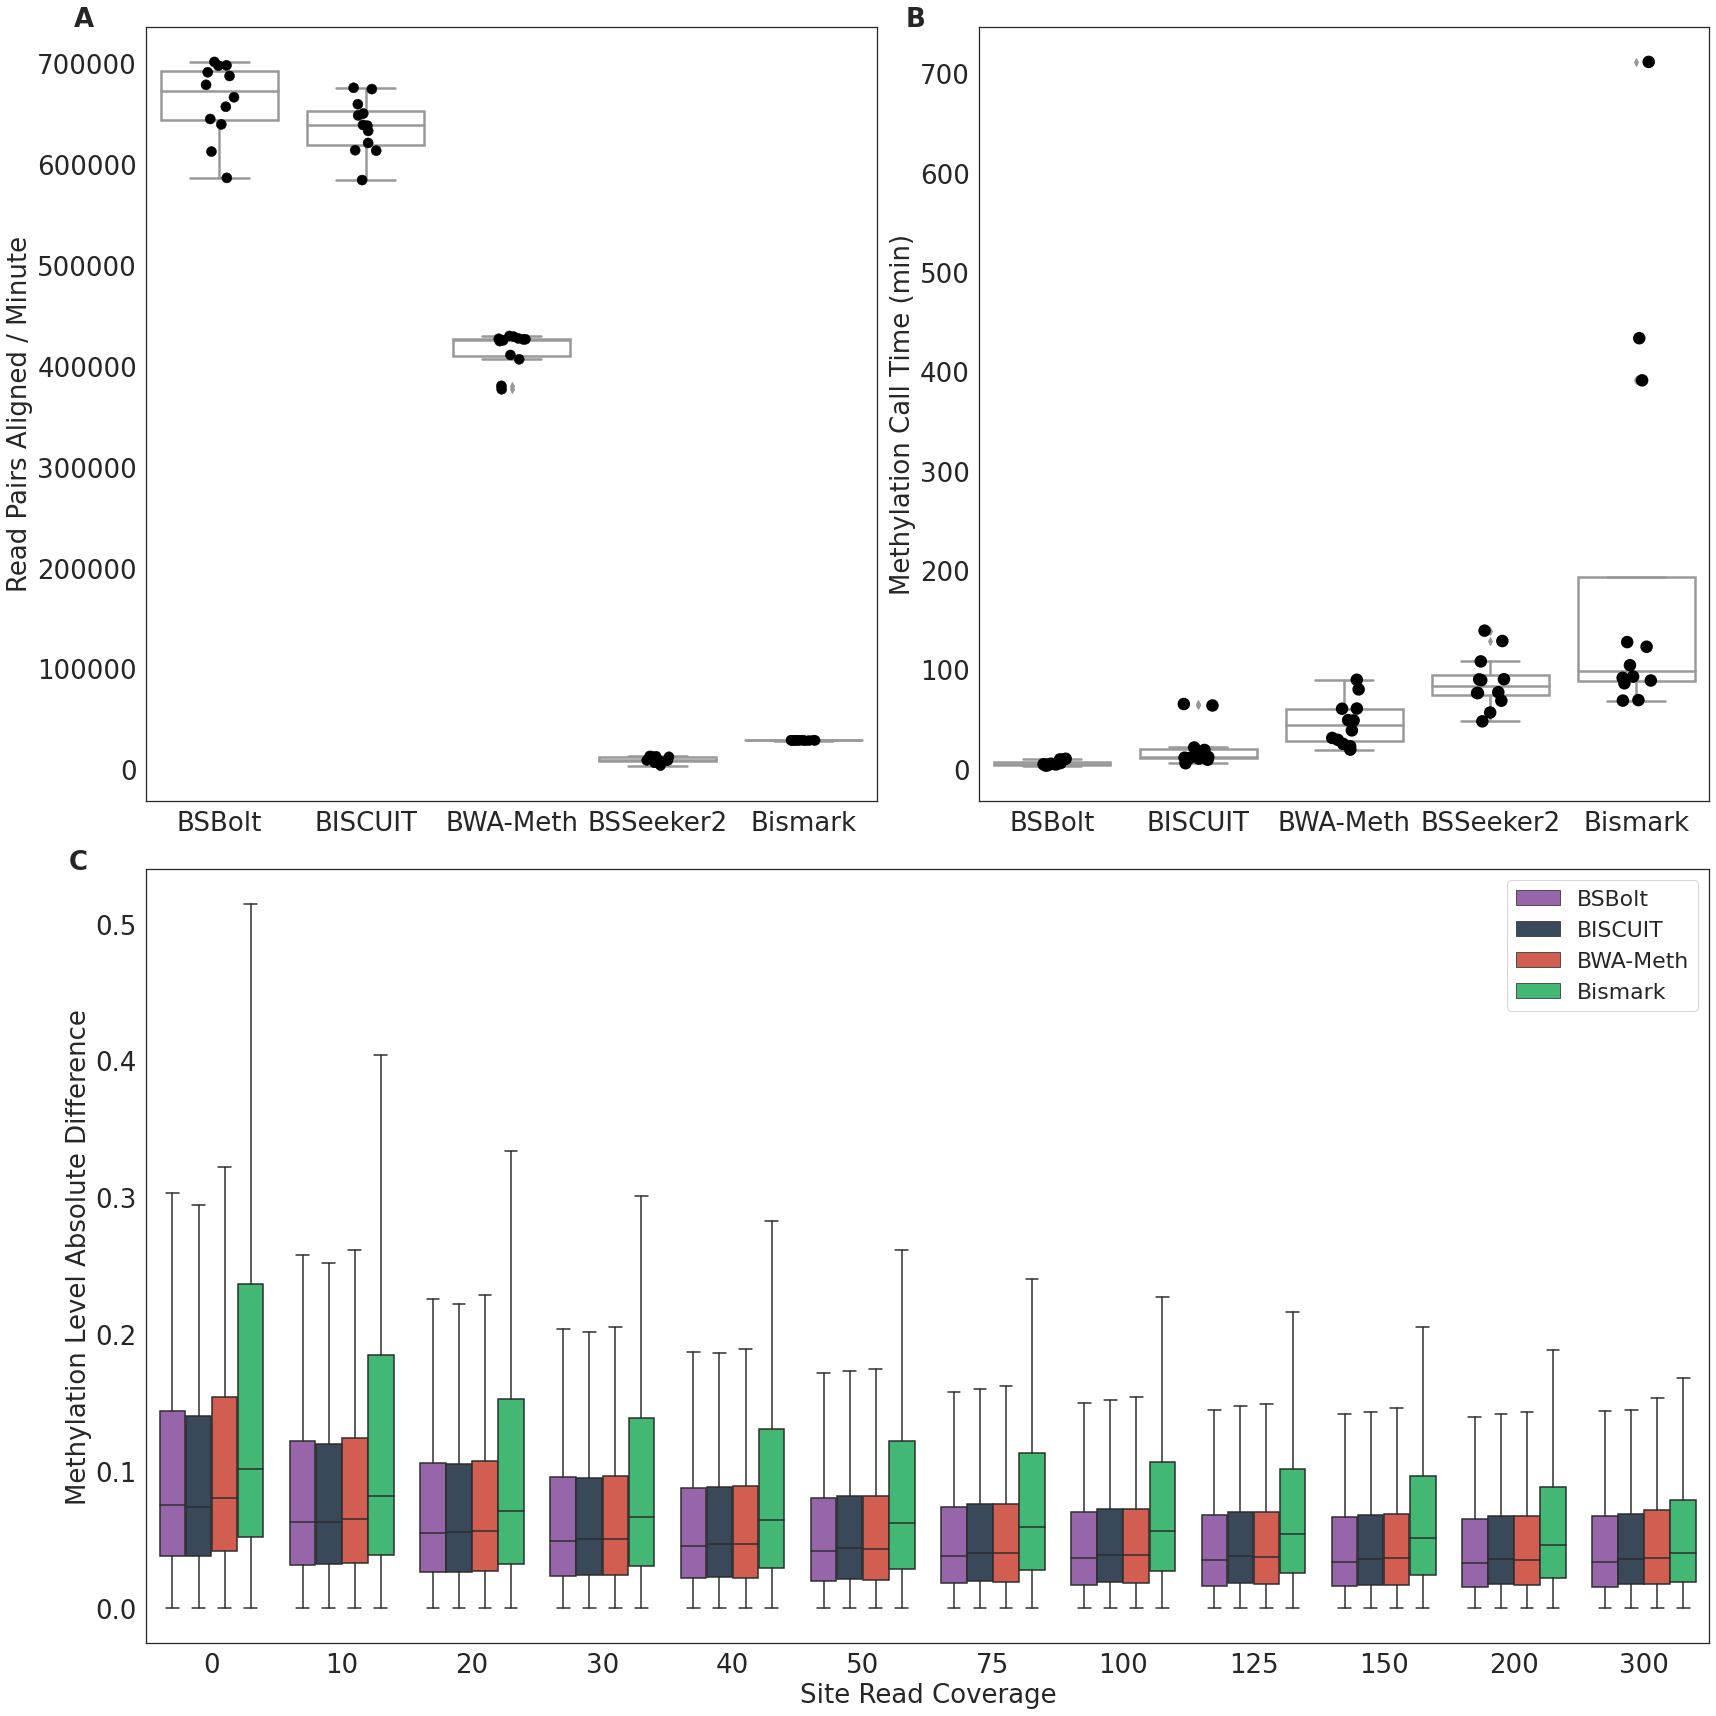

In [54]:
# plot the model results 

fig = plt.figure(figsize=(24,24))
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

tool_order = ['BSBolt', 'BISCUIT', 'BWA-Meth','BSSeeker2', 'Bismark']

sns.boxplot(x='Tool', y='Read Pairs Aligned / Minute', data=comp_df, ax=ax1, order=tool_order, 
            linewidth=2.5, color='white')
sns.stripplot(x='Tool', y='Read Pairs Aligned / Minute', data=comp_df, ax=ax1, order=tool_order, 
              jitter=True, dodge=True, linewidth=0.5, color='black', s=10)


sns.boxplot(x='Tool', y='Methylation Call Time (min)', data=comp_df, ax=ax2, order=tool_order, 
            linewidth=2.5, color='white')
sns.stripplot(x='Tool', y='Methylation Call Time (min)', data=comp_df, ax=ax2, order=tool_order, 
            linewidth=2.5, jitter=True, dodge=True, s=10, color='black')

flatui = ["#9b59b6", "#34495e", "#e74c3c", "#2ecc71", "cyan"]   
cov = np.digitize(coverage, coverage_bins)
#sns.lineplot(x=cov, y=array_diff, ax=ax3, hue=coverage_tools, hue_order=['BSBolt', 'BISCUIT', 'BWA-Meth', 'Bismark', 'BSSeeker2'], 
#             lw=2.5, palette=flatui, n_boot=1)
sns.boxplot(x=cov, y=array_diff, ax=ax3, hue=coverage_tools, hue_order=['BSBolt', 'BISCUIT', 'BWA-Meth', 'Bismark'], 
            palette=flatui, showfliers=False)
ax3.set_ylabel('Methylation Level Absolute Difference')
ax3.set_xlabel('Site Read Coverage')
ax3.set_xticks([x for x in range(max(cov) + 1)])
ax3.set_xticklabels(['0'] +[str(x) for x in coverage_bins])



#sns.boxplot(x='Tool', y='Methylation Call Time (min)', hue='Simulated Read Depth', data=plot_df, ax=ax[1,0], order=['BSBolt', 'BISCUIT', 'bwa-meth','BSSeeker2', 'Bismark'], linewidth=2.5)
#sns.boxplot(x='Tool', y='CpG Meth Level MAE', hue='Sequencing Error', data=plot_df, ax=ax[1,1], order=['BSBolt', 'BISCUIT', 'bwa-meth','BSSeeker2', 'Bismark'], linewidth=2.5)
ax1.text(-0.1,1, f'A', transform=ax1.transAxes, fontsize=26, weight='bold')
ax2.text(-0.1,1, f'B', transform=ax2.transAxes, fontsize=26, weight='bold')
ax3.text(-0.05,1, f'C', transform=ax3.transAxes, fontsize=26, weight='bold')


ax1.set_xlabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.savefig('Figure3.png', dpi=100)
plt.show()

### Export Comp Stats

In [55]:
output_df = comp_df.copy()

In [56]:
float_format_cats = ['Read Pairs Aligned / Minute',
 'Alignment Time (hrs)',
 'Mean Absolute Difference (Array, Sequencing Methylation Calls)',
 'Mean Absolute Difference Std. Dev.',
 'Pearson\'s R (Array, Sequencing Methylation Calls)',
 'Mean CpG Read Coverage',
 'Mean CpG Read Coverage Std. Dev.',
 'Methylation Call Time (min)']

In [57]:
for cat in float_format_cats:
    output_df[cat] = output_df[cat].map('{:,.2f}'.format)

In [58]:
output_df.to_csv('WGBS_Comps.tsv', index=False, sep='\t')

### Compare Alignment Groupings

In [59]:
tool_stat_cats =  ['Paired End Reads',
 'Read Pairs Aligned / Minute',
 'Alignment Time (hrs)',
 'Total Alignments',
 'Mapped Reads',
 'Unobserved Reads',
 'Unaligned Reads',
 'Mappability',
 'Secondary Alignments',
 'Supplementary Alignments',
 'Duplicate Alignments',
 'Properly Paired Alignments',
 'QC-Failed Alignments',
 'Mean Absolute Difference (Array, Sequencing Methylation Calls)',
 'Mean Absolute Difference Std. Dev.',
 'Mean CpG Read Coverage',
 'Mean CpG Read Coverage Std. Dev.',
 'Methylation Call Time (min)']

In [60]:
tool_stats = {}

for tool in set(tool_names.values()):
    tool_df = comp_df.loc[comp_df['Tool'] == tool]
    for dna_input in ['High (>1000ng)', 'Medium (300-1000ng)', 'Low (<300ng)']:
        input_df = tool_df.loc[tool_df['DNA Input'] == dna_input]
        stats = input_df[tool_stat_cats].mean(axis=0).to_dict()
        stats['DNA Input'] = dna_input
        tool_stats[f'{tool} {dna_input}'] = stats
    stats = tool_df[tool_stat_cats].mean(axis=0).to_dict()
    stats['DNA Input'] = 'All'
    tool_stats[f'{tool}  All'] = stats

In [61]:
tool_stats_df = pd.DataFrame(tool_stats).T

In [62]:
all_tool = tool_stats_df.loc[tool_stats_df['DNA Input'] == 'All']

In [63]:
tool_stats_df.to_csv('targeted_bs_stats.tsv', sep='\t')